In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import os
import jax.numpy as np
from jax import random, vmap
from jax import jit, lax, random

from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from numpyro.infer import MCMC, NUTS, HMC, SVI, ELBO, RenyiELBO
from numpyro import optim

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
numpyro.set_host_device_count(4)


In [2]:
import datetime as dt
from tools import *
datadir = '/'.join(os.getcwd().split('/')[:-1])+"/2_Data/"
# Functions
@logger
def select_meter(df, meter=0): # Electricity = 0
    return df[df.meter==0].drop(columns=['meter'])

@logger
def drop_outliers(df, threshold=5000): # does this threshold makes sense?
    return df[df.meter_reading<threshold]

@logger
def to_datetime(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

def compute_error(trues, predicted):
    try:
        corr = np.corrcoef(predicted, trues)[0,1]
    except:
        corr = 0
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [3]:
# Load data into DataFrames and reduce memory
df_meta_raw = pd.read_csv(datadir+'building_metadata.csv')
df_raw = pd.read_csv(datadir+'train.csv')
df_weather_raw = pd.read_csv(datadir+'weather_train.csv')

df = (df_raw.pipe(start_pipeline)
            .pipe(reduce_mem_usage)
            .pipe(select_meter) # only electricity
            #.pipe(drop_outliers) # check this threshold, we haven't done any visual check
            .pipe(to_datetime))
df_meta = (df_meta_raw.pipe(start_pipeline)
                      .pipe(reduce_mem_usage))
df_weather = (df_weather_raw.pipe(start_pipeline)
                            .pipe(reduce_mem_usage)
                            .pipe(to_datetime))

start_pipeline took 0:00:00 secs, shape(20216100, 4)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(20216100, 4)
select_meter took 0:00:00 secs, shape(12060910, 3)
to_datetime took 0:00:00 secs, shape(12060910, 3)
start_pipeline took 0:00:00 secs, shape(1449, 6)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
reduce_mem_usage took 0:00:00 secs, shape(1449, 6)
start_pipeline took 0:00:00 secs, shape(139773, 9)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(139773, 9)
to_datetime took 0:00:00 secs, shape(139773, 9)


In [4]:
# Filter raw datasets to include only households
df_meta = df_meta[df_meta.primary_use.eq('Lodging/residential')]
hh_id = df_meta.building_id.unique()
df = df[df.building_id.isin(hh_id)]
hh_id2 = df.building_id.unique() # repeat because 2 ids are missing from df_meta
df_meta = df_meta[df_meta.building_id.isin(hh_id2)]
hh_site_id = df_meta.site_id.unique()
df_weather = df_weather[df_weather.site_id.isin(hh_site_id)]

In [5]:
# Join datasets
df = df.set_index('building_id').join(df_meta.set_index('building_id'), how='inner')
df = df.reset_index() # to keep building_id
#df = df.set_index('timestamp').merge(df_weather.set_index('timestamp'),
#                                    on=['site_id', 'timestamp'],
#                                    how='left')

#Drop unused variables
df = df.drop(columns=['primary_use',
                      'floor_count',
 #                     'cloud_coverage',
#                      'precip_depth_1_hr',
#                      'wind_direction'
                     ])

In [6]:
# Sample from DataFrame
df = df.set_index('timestamp')
df_test = df.dropna(axis=0)
df_small = df_test.sample(frac=0.1)
df_small['week'] = df_small.index.week
df_small['day'] =  df_small.index.weekday

In [7]:
# Prepare matrix with time features
X_time = np.concatenate([pd.get_dummies(df_small[x]) for x in ["week", "day"]], axis=1)
X_site_id = pd.get_dummies(df_small.site_id)
X_rest = df_small.drop(columns=['meter_reading', 'site_id', 'week', 'day', 'building_id'])

# Scale X_rest
X_rest -= X_rest.mean()
X_rest /= X_rest.std()

In [8]:
# Join matrices
X = np.concatenate((X_rest.values, X_site_id.values), axis=1)
print(X.shape)

(69556, 9)


In [9]:
# Transform target variable
y = df_small.meter_reading.values
mean = y.mean()
std = y.std()
y = (y - mean)/std

In [10]:
import numpy
# Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(y))
perm = numpy.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]

In [11]:
#create a mapping between building_ids and individual ids, because we need a continuous range of ids
mapping = {key: value for value, key in enumerate(set(df_small.building_id))}
inds = np.array([mapping[h_id] for h_id in df_small.building_id])
ind_train = inds[ix_train]
ind_test = inds[ix_test]
sites = df_small.site_id
sites_train = sites[ix_train].values
sites_test = sites[ix_test].values
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 52167
num test: 17389


In [12]:
# Prepare data for Pyro model
#X_train_torch = torch.tensor(X_train).float()
#y_train_torch = torch.tensor(y_train).float()

In [13]:
def model(X, obs=None):
    alpha = numpyro.sample("alpha", dist.Normal(0., 5.))                   # Prior for the bias/intercept
    beta  = numpyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            5.*torch.ones(X.shape[1])))    # Priors for the regression coeffcients
    sigma = numpyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with numpyro.plate("data"):
        y = numpyro.sample("y", dist.Norma(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

Extending the simple linear model, we build a hierachical model, by assuming different biases for each household.

In [14]:
def hierarchical_model(X, ind, n_households, site, n_sites, obs=None):
    N, M = X.shape
    
    alpha_mu = numpyro.sample("alpha_mu", dist.Normal(0., 5.))
    alpha_sigma = numpyro.sample("alpha_sigma", dist.HalfCauchy(5.))
    
    #beta = pyro.sample("beta", dist.Normal(torch.zeros(M), 5.*torch.ones(M)))
    beta_mu = numpyro.sample("beta_mu", dist.Normal(np.zeros(M), 5.*np.ones(M)))
    beta_sigma = numpyro.sample("beta_sigma", dist.HalfCauchy(5.*np.ones(M)))
    
    sigma = numpyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance

    # if we want different betas for each site    
    with numpyro.plate("areas", n_areas):
        beta = numpyro.sample("beta", dist.Normal(beta_mu, beta_sigma).to_event(1))
    
    # if we want different alphas for each household?    
    with numpyro.plate("individuals", n_households):
        alpha = numpyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event(0))
#        sigma = pyro.sample("sigma", dist.HalfCauchy(5.).to_event(0))                   # Prior for the variance for each household ??? Makes Sense?

    
    with numpyro.plate("data", N):
        y = numpyro.sample("y", dist.Normal(alpha[ind-1]+ np.einsum('ij,ij->i', X, beta[site-1]), sigma), obs=obs)
        
    return y


Another approach would be to take different beta's for each household but this is too expensive in terms for speed for now. Maybe try with different set of beta's for areas instead of households.

In [15]:
n_households = len(df.building_id.unique()) -1 # one cat for each household
n_areas = len(set(df.site_id)) -1

In [16]:
import jax.numpy as np
batch_size = 64
EPOCHS = 20
adam = optim.ClippedAdam(0.001)

guide = AutoMultivariateNormal(hierarchical_model)
svi = SVI(hierarchical_model, guide, adam, ELBO())
rng_key = random.PRNGKey(0)
rng_key, rng_key_init = random.split(rng_key, 2)
sample_X = X_train[0:batch_size]
sample_y = y_train[0:batch_size]
sample_site = sites_train[0:batch_size]
sample_ind = ind_train[0:batch_size]

svi_state = svi.init(rng_key_init, sample_X, sample_ind, n_households, sample_site, n_areas, sample_y)


In [17]:
def train_step(carry, inputs):
    inputs = X_train.reshape(1,-1), ind_train.reshape(1,-1), sites_train.reshape(1,-1), y_train.reshape(1,-1)
    state = carry
    state, loss = svi.update(state, X_train, ind_train, n_households, sites_train, n_areas, y_train)
    return (state), loss

In [18]:
### Too slow
#def train_step(svi_state):
#    batch_loss = 0
#    for i in range(batch_size, len(X_train), batch_size):
#        svi_state, loss = svi.update(svi_state, X_train[i:i+1], ind_train[i:i+1], n_households, sites_train[i:i+1], n_areas, y_train[i:i+1])
#        batch_loss += loss
#    batch_loss /= i
#    return svi_state, loss

In [19]:
import jax.numpy as np
for e in range(EPOCHS):
    # train
    svi_state, loss = lax.scan(train_step, svi_state, xs=(X_train, ind_train, sites_train, y_train))
    loss = loss.mean()
    #eval
    test_loss = svi.evaluate(svi_state, X_test, ind_test, n_households, sites_test, n_areas, y_test) / len(X_test)
    print(f"Epoch: {e}, Train Loss: {loss}, Test Loss: {test_loss}")

Epoch: 0, Train Loss: 126500.296875, Test Loss: 2.3311333656311035
Epoch: 1, Train Loss: 148043.65625, Test Loss: 2.1260123252868652
Epoch: 2, Train Loss: 156017.984375, Test Loss: 2.2408902645111084
Epoch: 3, Train Loss: 160262.296875, Test Loss: 1.8204957246780396
Epoch: 4, Train Loss: 165126.9375, Test Loss: 2.1056056022644043
Epoch: 5, Train Loss: 167288.109375, Test Loss: 6.383671760559082
Epoch: 6, Train Loss: 167120.875, Test Loss: 7.763355255126953
Epoch: 7, Train Loss: 166875.5625, Test Loss: 2.2013232707977295
Epoch: 8, Train Loss: 169354.171875, Test Loss: 2.424449920654297
Epoch: 9, Train Loss: 168725.796875, Test Loss: 6.200376033782959
Epoch: 10, Train Loss: 169087.125, Test Loss: 2.763640880584717
Epoch: 11, Train Loss: 169168.515625, Test Loss: 4.6715168952941895
Epoch: 12, Train Loss: 169497.796875, Test Loss: 2.507638692855835
Epoch: 13, Train Loss: 168919.234375, Test Loss: 2.706502676010132
Epoch: 14, Train Loss: 169760.890625, Test Loss: 2.3021810054779053
Epoch: 1

In [20]:
from numpyro.infer import Predictive
predictive = Predictive(model=hierarchical_model, guide=guide, num_samples=1000, return_sites=("alpha_mu", "beta_mu", "alpha", "beta"), parallel=True)
samples = predictive.get_samples(rng_key, X_train, ind_train, n_households, sites_train, n_areas, y_train)

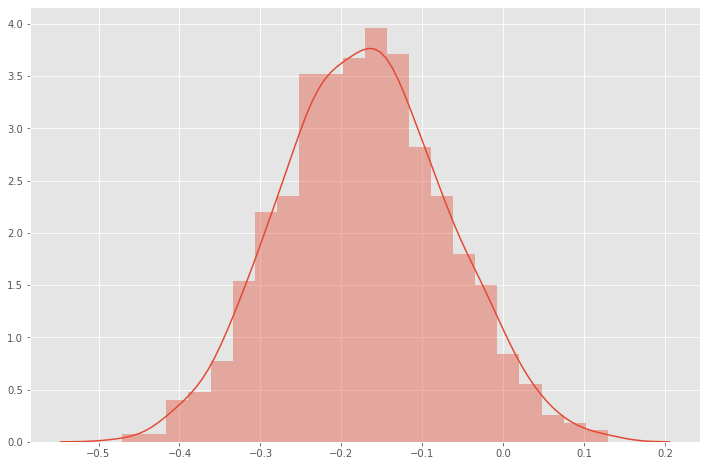

In [21]:
sns.distplot(samples['alpha_mu'])

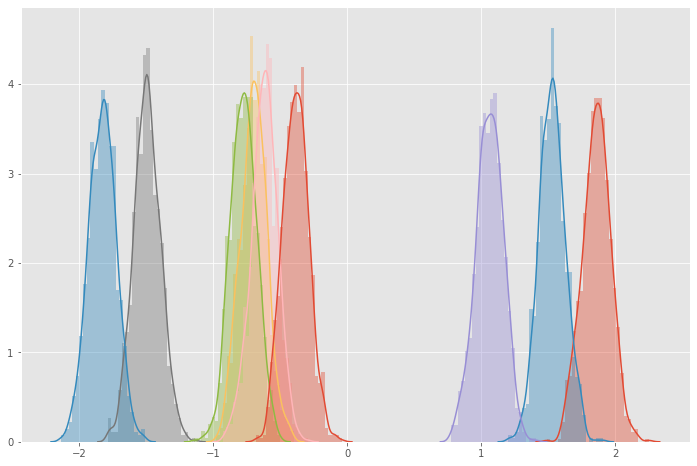

In [22]:
for i in range(samples["beta_mu"].shape[1]):
    sns.distplot(samples["beta_mu"][:,i])

In [23]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0)
beta_hat = samples["beta"].mean(axis=0)

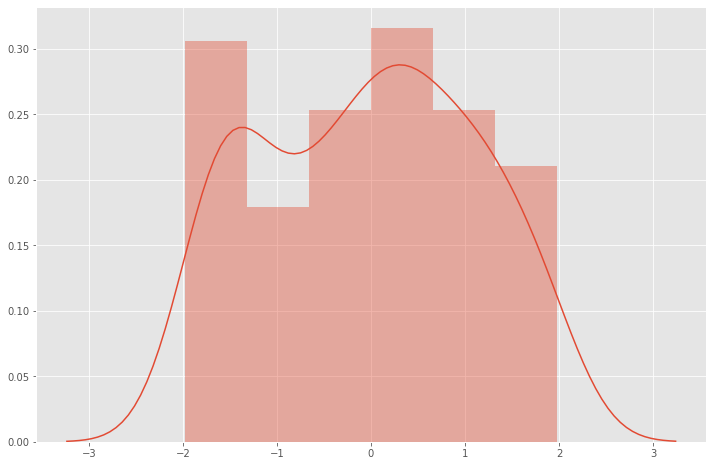

In [24]:
sns.distplot(alpha_hat)

In [25]:
beta_hat.shape

(11, 9)

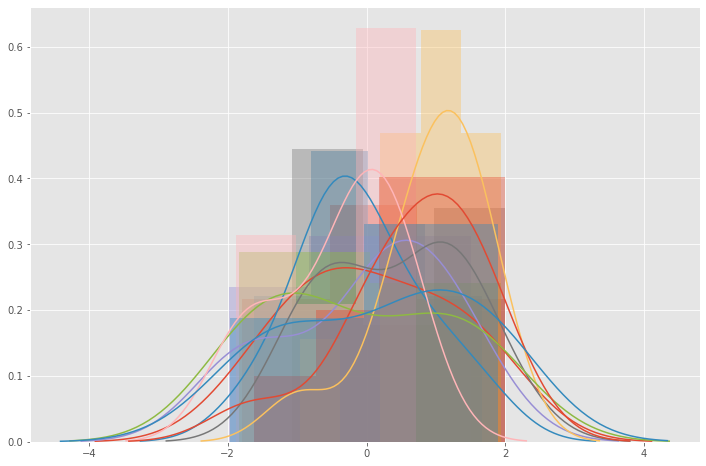

In [26]:
for i in range(beta_hat.shape[1]):
    sns.distplot(beta_hat[:,i])

In [27]:
# make predictions for test set
y_hat = alpha_hat[ind_test-1] + np.dot(X_test, beta_hat[sites_test-1,:].T)
y_hat = y_hat.mean(axis=1)

In [28]:
# convert back to the original scale
preds = y_hat * std + mean
y_true = y_test * std + mean

In [29]:
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.000
MAE: 180.148
RMSE: 208.734
R2: 0.000


Text(0, 0.5, 'True')

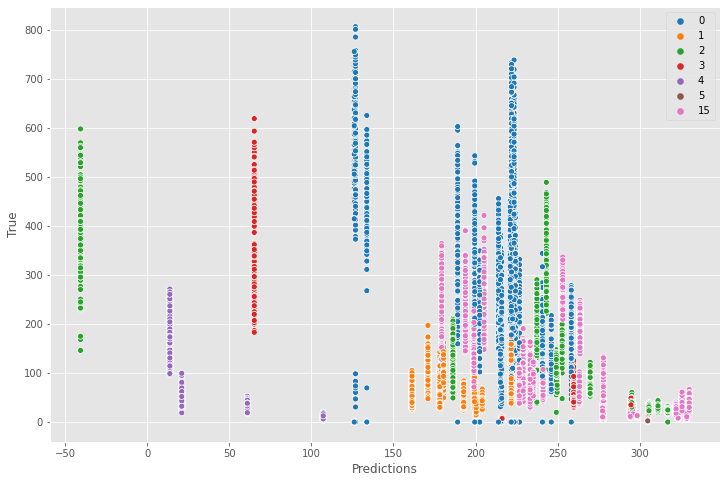

In [30]:
sns.scatterplot(preds.flatten(), y_true.flatten(), hue=sites_test, palette='tab10')
plt.xlabel("Predictions")
plt.ylabel("True")

# Notes
Does it make sense to have site id as a feature since we are doing a hierachical models based on that?